In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Импорт библиотек

In [39]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
120,121,0,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S
571,572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0,2,0,11769,51.4792,C101,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9000,NaN,S


## Выставление настроек

In [40]:
2+2

4

# Обработка данных

Начнем с того, что приведем все названия колонок к "змеиной нотации"

In [41]:
df.columns = df.columns.str.lower()
test.columns = test.columns.str.lower()

Переведем колонку с индексом в индекс датафрейма

In [42]:
df = df.set_index('passengerid')
test = test.set_index('passengerid')

Выведем общую информацию об обучающем и тестовом датасетах

In [43]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(),
                          'Null Count': df.isna().sum(),
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [44]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
survived,891,0,int64,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891,0,int64,891.0,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
name,891,0,object,,,,,,,,
sex,891,0,object,,,,,,,,
age,714,177,float64,714.0,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891,0,int64,891.0,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891,0,int64,891.0,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
ticket,891,0,object,,,,,,,,
fare,891,0,float64,891.0,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
cabin,204,687,object,,,,,,,,


In [45]:
full_info(test)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
pclass,418,0,int64,418.0,2.26555,0.841838,1.0,1.0,3.0,3.0,3.0
name,418,0,object,,,,,,,,
sex,418,0,object,,,,,,,,
age,332,86,float64,332.0,30.27259,14.181209,0.17,21.0,27.0,39.0,76.0
sibsp,418,0,int64,418.0,0.447368,0.89676,0.0,0.0,0.0,1.0,8.0
parch,418,0,int64,418.0,0.392344,0.981429,0.0,0.0,0.0,0.0,9.0
ticket,418,0,object,,,,,,,,
fare,417,1,float64,417.0,35.627188,55.907576,0.0,7.8958,14.4542,31.5,512.3292
cabin,91,327,object,,,,,,,,
embarked,418,0,object,,,,,,,,


Выводы следующие:
* В обучающем датасете 891 наблюдение
* Пропуски есть в колонках с возрастом и номером кабины(?). Пропуски есть также и в тестовом датасете, поэтому модель должна уметь работать с ними
* Не все типы данных оптимальны
* есть небольшой дисбаланс в пользу погибших

Удалим признак с номером кабины, так как восстановить эту информацию и использовать далее не удастся

In [46]:
try:
    df = df.drop('cabin', axis=1)
    test = test.drop('cabin', axis=1)
except:
    print('Признака уже нет')

Поменяем типы данных

In [47]:
df['pclass'] = df['pclass'].replace({1: 'first', 2: 'second', 3: 'third'})
test['pclass'] = test['pclass'].replace({1: 'first', 2: 'second', 3: 'third'})

In [48]:
df['sex'] = df['sex'].replace({'male': 0, 'female': 1}).astype('bool')
test['sex'] = test['sex'].replace({'male': 0, 'female': 1}).astype('bool')

Добавим новый признак, равный длине имени. Позже проверим, как это влияет на шансы выжить

In [49]:
df['name_length'] = df['name'].apply(len)
test['name_length'] = test['name'].apply(len)

Посмотрим на признак "номер билета"

In [50]:
df['ticket'].value_counts()

ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

Совпадающих значений мало, удалим признак

In [51]:
df = df.drop('ticket', axis=1)
test = test.drop('ticket', axis=1)

# Исследование данных

Построим по порядку для всех признаков графики, позволяющие пока визуально оценить влияние признака на целевую переменную

## Номер класса

In [52]:
df.groupby('pclass')['survived'].value_counts(normalize=True).round(2)

pclass  survived
first   1           0.63
        0           0.37
second  0           0.53
        1           0.47
third   0           0.76
        1           0.24
Name: proportion, dtype: float64

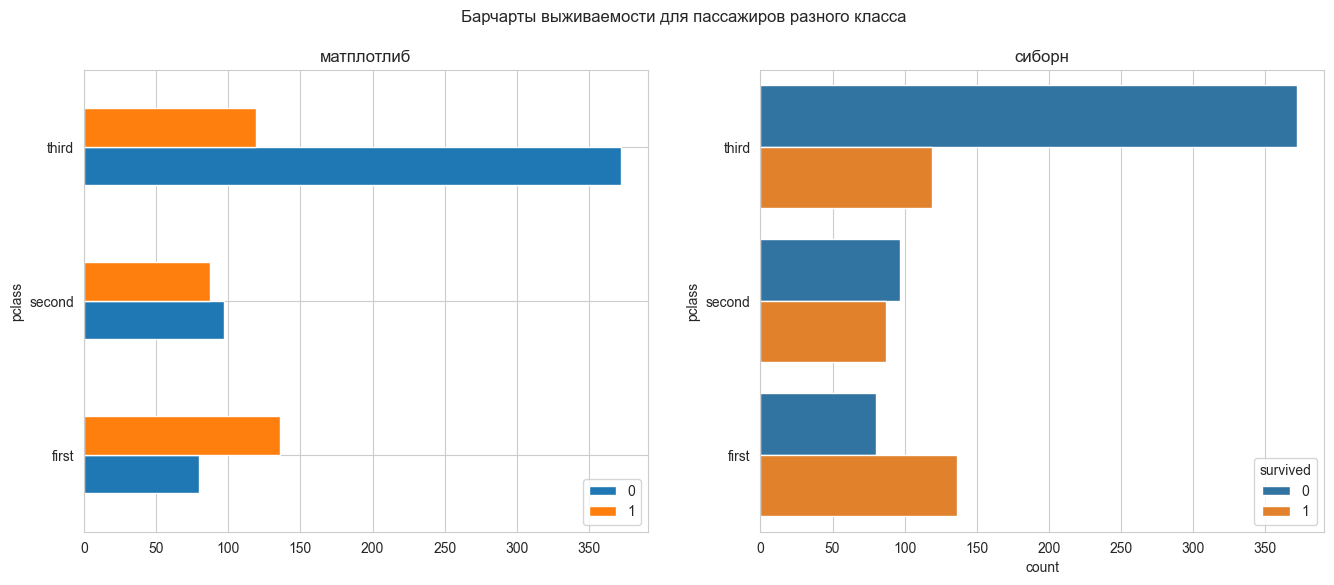

In [53]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle('Барчарты выживаемости для пассажиров разного класса')
df.groupby(['pclass', 'survived'])['survived'].value_counts().unstack().plot.barh(ax=ax1);
ax1.legend(loc='lower right');
ax1.set_title('матплотлиб')

sns.barplot(data=df.groupby(['pclass', 'survived'])['survived'].value_counts().reset_index(),
            y='pclass',
            order=['third', 'second', 'first'],
            x='count',
            hue='survived',
            # hue_order=[0, 1],
            orient='h',
            ax=ax2);
ax2.set_title('сиборн');

Предсказуемо, шансы выжить у пассажиров первого класса были выше

## Имя

Проверим, существует ли связь между длиной имени и вероятностью выжить.

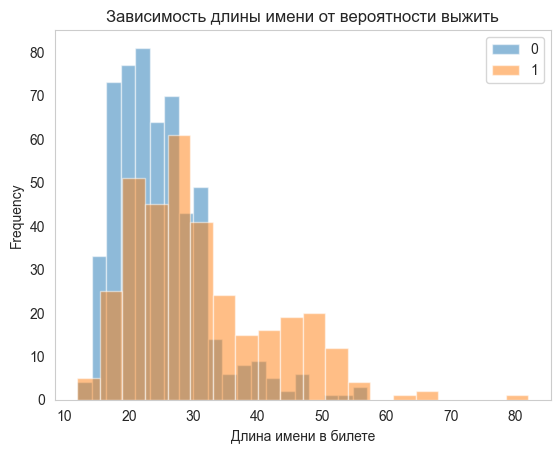

In [54]:
df.groupby('survived')['name_length'].plot(bins=20, alpha=0.5, kind='hist', grid=False);
plt.legend();
plt.title('Зависимость длины имени от вероятности выжить')
plt.xlabel('Длина имени в билете');

Удалим признак с именем

In [55]:
df = df.drop('name', axis=1)

## Пол

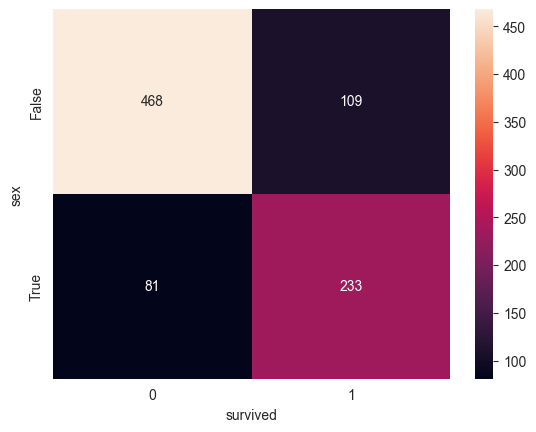

In [56]:
sns.heatmap(df.groupby(['sex', 'survived'])['survived'].count().unstack(), annot=True, fmt='.3g');

Среди женщин выжило примерно 75%, среди мужчин - 20%

## Возраст

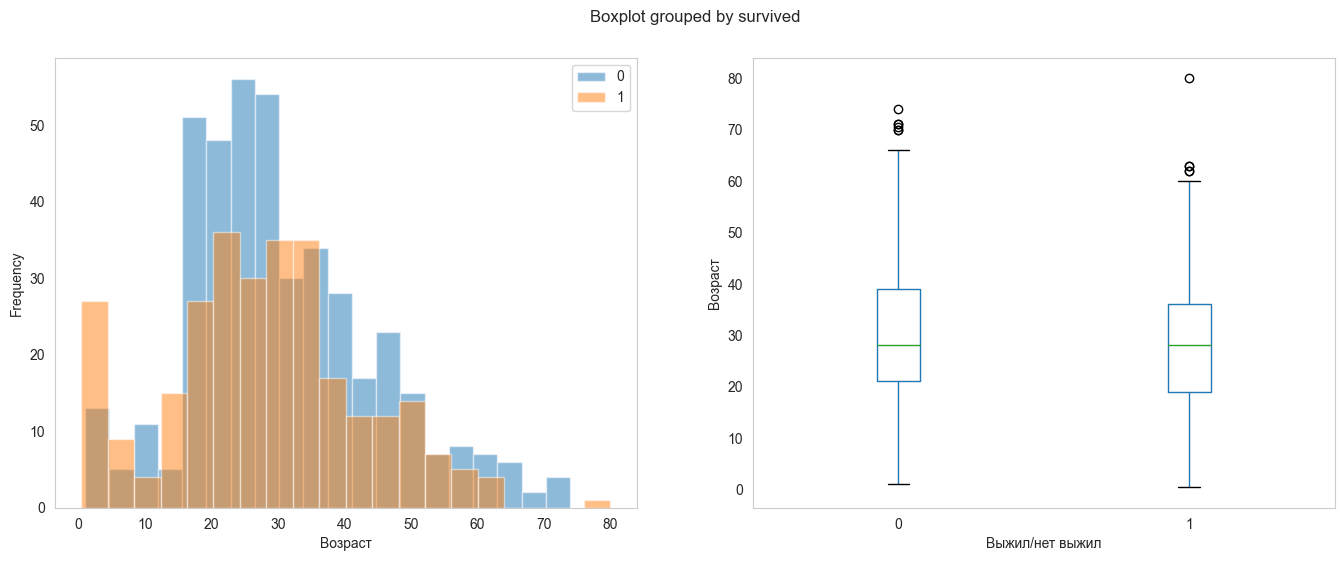

In [57]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

# fig.title('a')
fig.suptitle('b')
plt.title('c')
plt.suptitle('d')

df.groupby('survived')['age'].plot(bins=20, alpha=0.5, kind='hist', grid=False, ax=ax1);
ax1.legend();
ax1.set_xlabel('Возраст');

df.boxplot(column='age', by='survived', grid=False, ax=ax2);
ax2.set_xlabel('');
ax2.set_title('')
ax2.set_xlabel('Выжил/нет выжил')
ax2.set_ylabel('Возраст');

# Обучение моделей

## Разделение датасета на признаки и таргет

In [58]:
x = df.drop('survived', axis=1)
y = df['survived']

## Линейные модели

Построим пайплайн преобразования признаков для линейной модели

In [59]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first'))])

transformer = ColumnTransformer(transformers=[('nums', num_ct, selector(dtype_exclude="object")),
                                              ('cats', cat_ct, selector(dtype_include="object"))],
                                remainder='passthrough')
Pipeline(steps=[('', transformer)])

Pipeline(steps=[('',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nums',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000232A196C940>),
                                                 ('cats',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000232A196CB80>)]))])

Посмотрим на получившиеся признаки. У них теперь нет имен, но по порядку преобразвоаний можно увидеть, что последние 4 признака - это категориальные признаки, подвергнутые OHE.

In [60]:
full_info(pd.DataFrame(transformer.fit_transform(x)).astype('float'))

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
0,891,0,float64,891.0,3.987333e-17,1.000562,-0.737695,-0.737695,-0.737695,1.355574,1.355574
1,891,0,float64,891.0,2.232906e-16,1.000562,-2.253155,-0.592481,0.000000,0.407926,3.870872
2,891,0,float64,891.0,4.386066e-17,1.000562,-0.474545,-0.474545,-0.474545,0.432793,6.784163
3,891,0,float64,891.0,5.382900e-17,1.000562,-0.473674,-0.473674,-0.473674,-0.473674,6.974147
4,891,0,float64,891.0,3.987333e-18,1.000562,-0.648422,-0.489148,-0.357391,-0.024246,9.667167
5,891,0,float64,891.0,-1.415503e-16,1.000562,-1.613257,-0.750853,-0.211850,0.327152,5.932777
6,891,0,float64,891.0,2.065095e-01,0.405028,0.000000,0.000000,0.000000,0.000000,1.000000
7,891,0,float64,891.0,5.510662e-01,0.497665,0.000000,0.000000,1.000000,1.000000,1.000000
8,891,0,float64,891.0,8.641975e-02,0.281141,0.000000,0.000000,0.000000,0.000000,1.000000
9,891,0,float64,891.0,7.250281e-01,0.446751,0.000000,0.000000,1.000000,1.000000,1.000000


Добавим в пайплайн классификатор

In [82]:
lr_pipe = Pipeline(steps=[('transformer', transformer), ('clf', LogisticRegression())])

params = [{'transformer__nums__imputer': [SimpleImputer()],
           'transformer__nums__imputer__strategy': ['mean', 'median'],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          },
          { 'transformer__nums__imputer': [IterativeImputer()],
           'clf__penalty': ['none', 'l2'],
           'clf__C': [0.1, 1, 10, 100]
          }]

lr_gs    = GridSearchCV(estimator=lr_pipe,
                        param_grid=params,
                        scoring='roc_auc',
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10)
lr_gs.fit(x, y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('nums',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000232A196C940>),
                                                                        ('cats',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_fre...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000232A196CB80>)])),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.1, 1, 10, 100],
                          'clf__penalty': ['none', 'l2'],
                          'transformer__nums__imputer': [SimpleImputer()],
                          'transformer__nums__imputer__strategy': ['mean',
                                                                   'median']},
                         {'clf__C': [0.1, 1, 10, 100],
                          'clf__penalty': ['none', 'l2'],
                          'transformer__nums__imputer': [IterativeImputer()]}],
             scoring='roc_auc', verbose=10)

In [83]:
pd.DataFrame(lr_gs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_transformer__nums__imputer,param_transformer__nums__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
19,0.072333,0.009673,0.014000,0.000816,1,l2,IterativeImputer(),NaN,"{'clf__C': 1, 'clf__penalty': 'l2', 'transform...",0.839133,0.862957,0.855119,0.852403,0.009914,1
20,0.070667,0.009177,0.013666,0.000472,10,none,IterativeImputer(),NaN,"{'clf__C': 10, 'clf__penalty': 'none', 'transf...",0.838414,0.861806,0.856941,0.852387,0.010078,2
18,0.070335,0.005794,0.016333,0.001884,1,none,IterativeImputer(),NaN,"{'clf__C': 1, 'clf__penalty': 'none', 'transfo...",0.838414,0.861806,0.856941,0.852387,0.010078,2
16,0.070334,0.002623,0.018666,0.002055,0.1,none,IterativeImputer(),NaN,"{'clf__C': 0.1, 'clf__penalty': 'none', 'trans...",0.838414,0.861806,0.856941,0.852387,0.010078,2
22,0.063666,0.001247,0.010331,0.000943,100,none,IterativeImputer(),NaN,"{'clf__C': 100, 'clf__penalty': 'none', 'trans...",0.838414,0.861806,0.856941,0.852387,0.010078,2
21,0.064000,0.002944,0.013333,0.000943,10,l2,IterativeImputer(),NaN,"{'clf__C': 10, 'clf__penalty': 'l2', 'transfor...",0.838462,0.861710,0.856845,0.852339,0.010011,6
23,0.049663,0.005249,0.006666,0.000944,100,l2,IterativeImputer(),NaN,"{'clf__C': 100, 'clf__penalty': 'l2', 'transfo...",0.838462,0.861710,0.856797,0.852323,0.010004,7
6,0.035002,0.003558,0.015000,0.000001,1,l2,SimpleImputer(),mean,"{'clf__C': 1, 'clf__penalty': 'l2', 'transform...",0.839804,0.861135,0.854688,0.851876,0.008932,8
10,0.033666,0.002624,0.014333,0.000472,10,l2,SimpleImputer(),mean,"{'clf__C': 10, 'clf__penalty': 'l2', 'transfor...",0.838606,0.860128,0.855742,0.851492,0.009286,9
14,0.032668,0.002357,0.013666,0.000472,100,l2,SimpleImputer(),mean,"{'clf__C': 100, 'clf__penalty': 'l2', 'transfo...",0.838366,0.859889,0.855982,0.851412,0.009362,10


In [88]:
lr = lr_gs.best_estimator_

In [90]:
dir(lr)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_can_inverse_transform',
 '_can_transform',
 '_check_feature_names',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_iter',
 '_log_message',
 '_more_tags',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_sk_visual_block_',
 '_validate_data',
 '_validate_names',
 '_validate_params',
 '_validate_steps',
 

In [96]:
lr.named_steps['clf'].coef_

array([[ 1.13070513, -0.54454893, -0.46106546, -0.15139654,  0.1896602 ,
         0.39716796, -0.69978659, -1.8592616 ,  0.04168653, -0.51174865]])

In [97]:
x

,pclass,sex,age,sibsp,parch,fare,embarked,name_length
passengerid,,,,,,,,
1,third,False,22.0,1,0,7.2500,S,23
2,first,True,38.0,1,0,71.2833,C,51
3,third,True,26.0,0,0,7.9250,S,22
4,first,True,35.0,1,0,53.1000,S,44
5,third,False,35.0,0,0,8.0500,S,24
...,...,...,...,...,...,...,...,...
887,second,False,27.0,0,0,13.0000,S,21
888,first,True,19.0,0,0,30.0000,S,28
889,third,True,NaN,1,2,23.4500,S,40
